# Training a model to classify images of Pets

This first cell loads the images from the cat and dog folders and turn them into arrays. We are only using 300 images per category so everyone can run, but feel free to increase that number if your computer can handle more data. 

In [ ]:
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

images_to_use = 300 # increase this number if you want to use more data

cat_path = './cat' # edit with the path to the folder with your cat data
dog_path = './dog' # edit with the path to the folder with your dog data
dog_files = [dog_path + "/" + f for f in listdir(dog_path) if isfile(join(dog_path, f))][:images_to_use]
cat_files = [cat_path + "/" + f for f in listdir(cat_path) if isfile(join(cat_path, f))][:images_to_use]

files = dog_files + cat_files

X = []
y = []


for file in files:
    label = file.split('/')[1] # gets the folder name
    y.append(label)
    img = load_img(file, target_size=(224, 224))
    img = img_to_array(img)
    X.append(img)

The following cell splits your data into train, validation and test. It performs transformations to turn a colored image, which has 3 values per pixel in the RGB color model (https://en.wikipedia.org/wiki/RGB_color_model), into a matrix of single values that combine the 3 RGB values.

In [13]:
from matplotlib import pyplot

from sklearn.model_selection import train_test_split

def flatten_X(X):
    return np.vstack([arr.flatten() for arr in X])

def rgb2gray(rgb):
    # this converts the RGB colors to gray, so you have only one value per pixel
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 

def transform_to_gray_features(X):
    gray_features = []
    for instance in X:
        X_gray = rgb2gray(instance)
        flattened_X_gray = X_gray.flatten()
        gray_features.append(flattened_X_gray)
    return np.vstack(gray_features)

def get_train_val_test(X, y, split=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    return X_train, y_train, X_test, y_test, X_val, y_val

X_train, y_train, X_test, y_test, X_val, y_val = get_train_val_test(X, y, split=0.2)

X_train_gray = transform_to_gray_features(X_train)
X_test_gray = transform_to_gray_features(X_test)
X_val_gray = transform_to_gray_features(X_val)



# plot first few images with the gray transform
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    
    # plot raw pixel data
    pyplot.imshow(rgb2gray(X_train[i]))
# show the figure
pyplot.show()

NameError: name 'X' is not defined

## Exercise 1: Train a model using the gray scaled features

For this exercise, you will import any model that you have worked with before, either from scikit-learn or any other library, and you will train it on the training set. You can test different hyperparameters using the validation set.


In [ ]:
# Add code here to train a model on the training data.

Now, use the classification report function from sklearn to show evaluate the results.

In [ ]:
from sklearn.metrics import classification_report


## Using Pre-trained models to extract features

In the cell below, we import the VGG16 model. We also have commented out the commands to use other existing pre-trained models from Keras.

In [ ]:
from keras.applications.vgg16 import VGG16
# from keras.applications import ResNet50
# from keras.applications import InceptionV3
# from keras.applications import Xception # TensorFlow ONLY
# from keras.applications import VGG16
# from keras.applications import VGG19


model = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
model.summary()

We run code to extract the features using the pre-trained model. Because we pass the flag `include_top=False` when loading the model, we get the vector of the last layer of the model before going through the Softmax function, instead of the model predictions. This vector should contain information about what is in the image.

In [ ]:
def extract_features_from_images(images):
    # Receives an array of images and transform it into an array of features from DL models
    features = []
    
    for img in images:
        img_proper_shape = np.expand_dims(img, axis=0) # adds another axis required by DL models 
        extracted_features = model.predict(img_proper_shape)
        flattened_features = extracted_features.flatten() # We make a single 1D array to represent the features
        features.append(flattened_features)
        
    return np.vstack(features)

In [ ]:
X_train_features = extract_features_from_images(X_train)

In [ ]:
X_test_features = extract_features_from_images(X_test)
X_val_features = extract_features_from_images(X_val)

## Exercise 2: Using the features extracted from pre-trained models

Now, use the same model you have used for exercise 1, but now train it on X_train_features, the features extracted using the Deep Learning models. You can test different hyperparameters using the validation set.

In [ ]:
# Add code to train a model on the features extracted using the Deep Learning model

Print the classification report results on the test set below.

In [ ]:
# Print the results from the classification report

## Bonus: Comparing different DL models

For Bonus points, try using different DL models to extract features. You can achieve that by changing the `model = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))` line of the code to use one of the other models from keras. ie. `model = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3))`. Don't forget you need to import the models by removing the comments in that cell. Compare at least 3 models and report the results.

In [ ]:
# Add code to compare the models here. This is an optional assignment.

# Training a model for Sentiment Analysis

For the second part of this homework, we will be training a Natural Language Processing model to make predictions on two datasets: Tweets and Reddit comments. We will be using the data downloaded from Canvas. The cell below loads the data and splits it into train, validation and test.

In [70]:
import pandas as pd

twitter_df = pd.read_csv('Twitter_Data.csv').dropna()
reddit_df = pd.read_csv('Reddit_Data.csv').dropna()

X_twitter = twitter_df['clean_text']
y_twitter = twitter_df['category'] + 1 # We sum 1 so the categories are not negative. Now Negative is 0, Neutral is 1 and Positive is 2

X_reddit = reddit_df['clean_comment']
y_reddit = reddit_df['category'] + 1


In [71]:
X_train_tweet, y_train_tweet, X_test_tweet, y_test_tweet, X_val_tweet, y_val_tweet = get_train_val_test(X_twitter, y_twitter, split=0.2)

In [72]:
X_train_reddit, y_train_reddit, X_test_reddit, y_test_reddit, X_val_reddit, y_val_reddit = get_train_val_test(X_reddit, y_reddit, split=0.2)

## Exercise 3: Using count-based methods to represent text documents.

Using what was you learned in class, train two models per dataset. The first one will be using [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and the second one will be using the [TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). You can use any model you want, but you should report the results using both feature vectors.

Report the values for the two models trained on Twitter and the two models trained on Reddit.

In [73]:
# Add code here to train the two models and report the results.

## Deep Learning and Word Embeddings



We will now use an LSTM to make predictions on the data. We will first compute the Vocabulary size for the two datasets.

In [74]:
twitter_vocabulary_size = len(set([tok for s in X_train_tweet.values.tolist() for tok in s.split()]))
reddit_vocabulary_size = len(set([tok for s in X_train_reddit.values.tolist() for tok in s.split()]))

print(f"Twitter' Vocabulary size is {twitter_vocabulary_size} and Reddit's Vocabulary size is {reddit_vocabulary_size}")

Twitter' Vocabulary size is 97988 and Reddit's Vocabulary size is 48143


Now we preprocess the data. To use it on Keras, we first need to change the words to numeric values. We also need to make all the sentences to be the same size for the matrix computations. To do that, we select a length to the text. 

If the text is shorter than the length, we pad it with zeros until it is has the correct size. The model will learn that zeros mean padding and will ignore it. 

If the text is longer than the length, we just discard the extra words.

In [75]:
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence

OOV_BUCKETS = 10
TEXT_LENGTH = 100
# Creates sequences for twitter_data
def converts_text_to_padded_sequences(X, vocabulary_size, oov=OOV_BUCKETS, max_review_length=TEXT_LENGTH):
    number_sequences =  [one_hot(sentence, vocabulary_size + oov ) for sentence in X.values.tolist()]
    padded_sequences = sequence.pad_sequences(number_sequences, maxlen=max_review_length)

    return padded_sequences

twitter_train_dl = converts_text_to_padded_sequences(X_train_tweet, twitter_vocabulary_size)
twitter_test_dl = converts_text_to_padded_sequences(X_test_tweet, twitter_vocabulary_size)
twitter_val_dl = converts_text_to_padded_sequences(X_val_tweet, twitter_vocabulary_size)


reddit_train_dl = converts_text_to_padded_sequences(X_train_reddit, reddit_vocabulary_size)
reddit_test_dl = converts_text_to_padded_sequences(X_test_reddit, reddit_vocabulary_size)
reddit_val_dl = converts_text_to_padded_sequences(X_val_reddit, reddit_vocabulary_size)

Now that we have all the train, validation and test splits for the two datasets, we will start by training a sentiment analysis model on Reddit data. The code below will train a one layer LSTM on the Reddit data. It will create n embeddings, being n the vocabulary size. It means that each word will have their own embedding and the model will learnr how to represent the words as it learns to perfom the task.

In [84]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest

my_callbacks = [
    keras.callbacks.EarlyStopping(patience=2),
    keras.callbacks.ModelCheckpoint(filepath="best_weights_reddit.hdf5", verbose=1, save_best_only=True),
]


def train_model(X_train, y_train, X_val, y_val, embedding_size, vocabulary_size, text_length, epochs, batch_size):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_size, input_length=text_length)) # We create embeddings for each word in our vocabulary
    model.add(LSTM(100)) # one layer of LSTM with 100 hidden units
    model.add(Dense(3, activation='softmax')) # Output softmax for the 3 classes, Negative, Neutral and Positive
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=my_callbacks)
    
    return model, history
  
# We train a model by passing the reddit data and parrameters related to reddit.
reddit_model, reddit_history = train_model(reddit_train_dl, y_train_reddit, reddit_val_dl, y_val_reddit, 
                             embedding_size=32, vocabulary_size=reddit_vocabulary_size+OOV_BUCKETS, 
                             text_length= TEXT_LENGTH, epochs=20, batch_size=64)



reddit_model.load_weights('best_weights_reddit.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 32)           1540896   
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 303       
Total params: 1,594,399
Trainable params: 1,594,399
Non-trainable params: 0
_________________________________________________________________
None
Train on 29719 samples, validate on 3715 samples
Epoch 1/20
29719/29719 [==============================] - 78s - loss: 0.6972 - acc: 0.6972 - val_loss: 0.4346 - val_acc: 0.8455
Epoch 2/20
29719/29719 [==============================] - 76s - loss: 0.2808 - acc: 0.9037 - val_loss: 0.3471 - val_acc: 0.8824
Epoch 3/20
29719/29719 [==============================] - 74s - loss: 0.1690 - acc: 0.

In [85]:
import matplotlib.pyplot as plt

def plot_history(history):
    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.grid(True)
    plt.show()

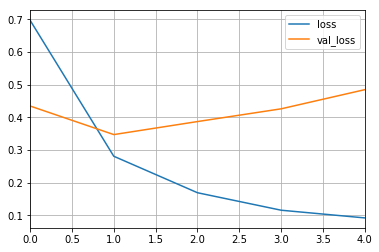

In [86]:
plot_history(reddit_history)

## Exercise 4: Train a sentiment analysis model on Twitter data

Now you will change the previous code to train a model on the Twitter data. You will tune the parameters using the Validation set results.

In [ ]:
#Add code here to train a model using the Twitter data. Add more cells if necessary

## Exercise 5: Compare the models

For this last exercise, you will compare all your models. You will make predictions on Twitter using your CountVectorizer, TFIDFVectorizer, and LSTM models and report the results using the classification report. You will do the same for the Reddit data.